In [119]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
import xarray as xr
import xbudget
import xwmb
from dask.diagnostics import ProgressBar

### Load diagnostics and infer required grid coordinates and metrics

In [121]:
from postprocess import *
ds = xr.open_zarr("rrexnum200.zarr")
grid = create_roms_grid(ds)
ds = grid._ds

In [122]:
rho0 = 1035.
chunks = {"xi_rho":ds.xi_rho.size, "s_rho":1}
chunks_u = {"xi_psi":ds.xi_psi.size, "s_rho":1}
grid._ds["umo"] = (rho0*(ds.u*ds.dy_u).chunk(chunks_u)*grid.interp(ds.thkcello.chunk(chunks), "X"))

chunks = {"eta_rho":ds.eta_rho.size, "s_rho":1}
chunks_v = {"eta_psi":ds.eta_psi.size, "s_rho":1}
grid._ds["vmo"] = (rho0*(ds.v*ds.dx_v).chunk(chunks_v)*grid.interp(ds.thkcello.chunk(chunks), "Y"))

In [123]:
xbudget_dict = xbudget.load_yaml("ROMS.yaml")
xbudget.collect_budgets(grid, xbudget_dict)

In [124]:
grid._ds = bite_sized_chunks(grid._ds)
grid._ds["sigma2"] = grid._ds["sigma2"].chunk({"xi_rho":-1, "eta_rho":-1})

In [125]:
import numpy as np
sigma2_bin_edges = np.linspace(34, 38, 200)
grid._ds = grid._ds.assign_coords({
    "sigma2_i_target": xr.DataArray(sigma2_bin_edges, dims=("sigma2_i_target",)),
    "sigma2_l_target": xr.DataArray((sigma2_bin_edges[1:] + sigma2_bin_edges[:-1])/2, dims=("sigma2_l_target",))
})

grid = xwmt.add_gridcoords(
    grid,
    {"Z_target": {"center": "sigma2_l_target", "outer": "sigma2_i_target"}},
    {"Z_target": "extend"}
)

wmb = xwmb.WaterMassBudget(
    grid,
    xbudget_dict,
    region=xr.ones_like(ds.areacello),
    rebin=True
)

In [126]:
wmt = wmb.mass_budget("sigma2", greater_than=True);

### Stratification for context

In [127]:
with ProgressBar():
    sigma2_mean_profile = grid._ds.sigma2.mean(["xi_rho", "eta_rho", "time"]).compute()
    z_l_mean_profile = grid._ds.z_l.mean(["xi_rho", "eta_rho", "time"]).compute()

[########################################] | 100% Completed | 2.91 sms
[########################################] | 100% Completed | 779.60 ms


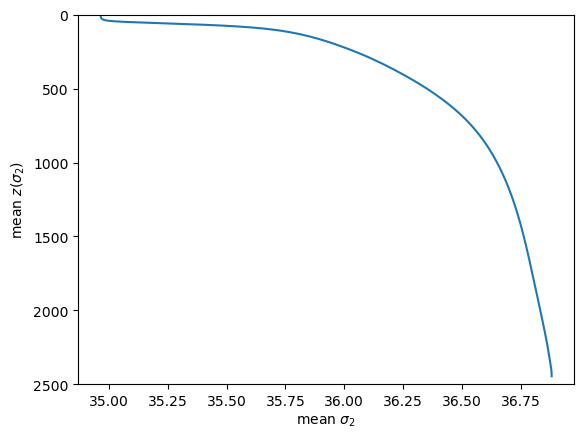

In [128]:
import matplotlib.pyplot as plt
plt.plot(sigma2_mean_profile, z_l_mean_profile)
plt.ylim(2500, 0)
plt.xlabel(r"mean $\sigma_{2}$")
plt.ylabel(r"mean $z(\sigma_{2})$");

### Mixing-driven WMT

In [129]:
with ProgressBar():
    wmt_diff = wmt.diffusion.compute()

[########################################] | 100% Completed | 7.46 sms


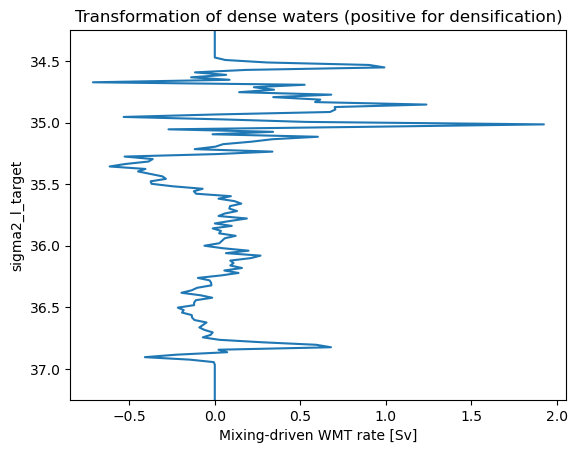

In [130]:
Sv_per_kgpers = 1e-6/rho0
(wmt_diff.mean("time")*Sv_per_kgpers).plot(y="sigma2_l_target")
plt.xlabel("Mixing-driven WMT rate [Sv]")
plt.title("Transformation of dense waters (positive for densification)")
plt.ylabel
plt.ylim(37.25, 34.25);

### Surface-forced WMT

In [133]:
with ProgressBar():
    wmt_surface = wmt.boundary_fluxes.compute()

[########################################] | 100% Completed | 5.93 sms


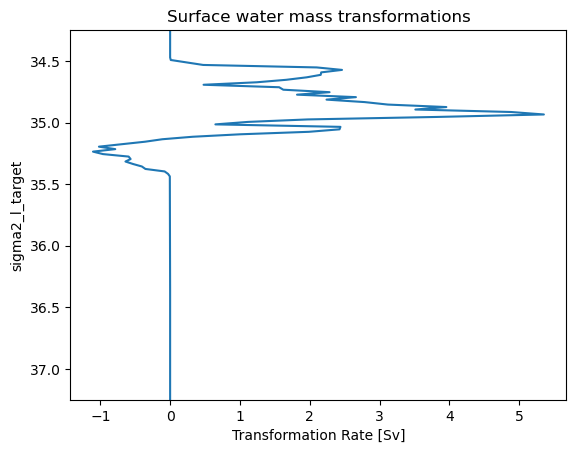

In [134]:
Sv_per_kgpers = 1e-6/rho0
(wmt_surface.mean("time")*Sv_per_kgpers).plot(y="sigma2_l_target")
plt.xlabel("Transformation Rate [Sv]")
plt.title("Surface water mass transformations")
plt.ylabel
plt.ylim(37.25, 34.25);

### Overturning

In [131]:
with ProgressBar():
    psi = wmt.convergent_mass_transport.compute()

[########################################] | 100% Completed | 51.69 s


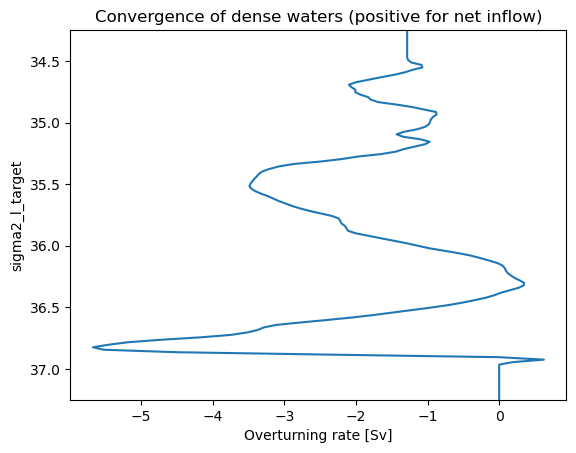

In [132]:
Sv_per_kgpers = 1e-6/rho0
(psi.mean("time")*Sv_per_kgpers).plot(y="sigma2_l_target")
plt.xlabel("Overturning rate [Sv]")
plt.title("Convergence of dense waters (positive for net inflow)")
plt.ylabel
plt.ylim(37.25, 34.25);

### Storage

In [135]:
with ProgressBar():
    dMdt = wmt.mass_tendency.compute()

[########################################] | 100% Completed | 13.59 s


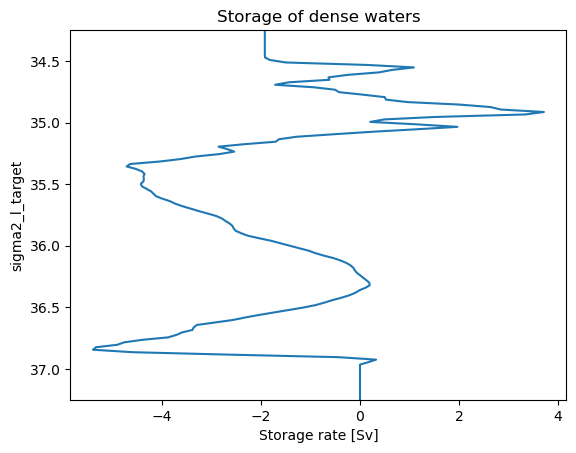

In [136]:
Sv_per_kgpers = 1e-6/rho0
(dMdt.mean("time")*Sv_per_kgpers).plot(y="sigma2_l_target")
plt.xlabel("Storage rate [Sv]")
plt.title("Storage of dense waters")
plt.ylabel
plt.ylim(37.25, 34.25);

### Water mass transformation budget residual and interpretation

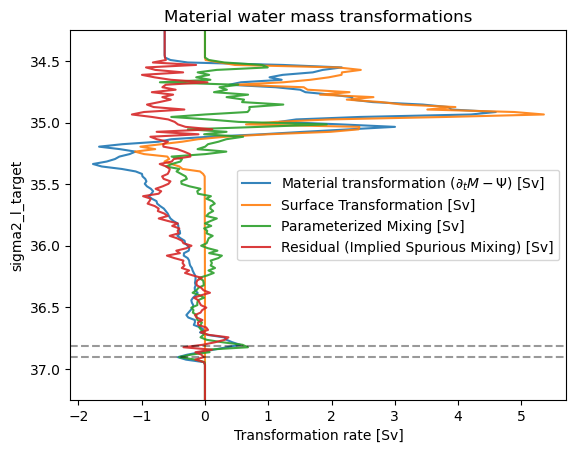

In [137]:
Sv_per_kgpers = 1e-6/rho0
((dMdt - psi).mean("time")*Sv_per_kgpers).plot(y="sigma2_l_target", label=r"Material transformation ($\partial_{t} M - \Psi$) [Sv]", alpha=0.9)
(wmt_surface.mean("time")*Sv_per_kgpers).plot(y="sigma2_l_target", label="Surface Transformation [Sv]", alpha=0.9)
(wmt_diff.mean("time")*Sv_per_kgpers).plot(y="sigma2_l_target", label="Parameterized Mixing [Sv]", alpha=0.9)
spurious_mixing = (dMdt - psi - wmt_diff - wmt_surface)
(spurious_mixing.mean("time")*Sv_per_kgpers).plot(y="sigma2_l_target", label="Residual (Implied Spurious Mixing) [Sv]", alpha=0.9)
plt.axhline(36.815, color="k", ls="--", alpha=0.4)
plt.axhline(36.9, color="k", ls="--", alpha=0.4)
plt.xlabel("Transformation rate [Sv]")
plt.title("Material water mass transformations")
plt.ylim(37.25, 34.25);
plt.legend()

### Brief interpretation and discussion

- On an hourly basis, the leading order balance is between horizontal mass convergence (overturning) and storage, especially for dense waters that do not outcrop and thus experience no surface-force WMT.
- Bottom waters ($\sigma_{2} > 36.9$) are transformed into lighter waters by mixing at a rate of ~-0.4 Sv. At slightly higher densities ($\sigma_{2} \simeq 36.815$), the mixing-induced transformation is positive, i.e. mixing causes densification. Both effects combine to form ~1 Sv of waters with densities between about 36.9 and 36.815, which must either be stored locally or be exported.
- Material transformations are dominated by surface transformations for $\sigma_{2} < 35$, representing about ~5 Sv of dense water formation.
- For the intermediate densities corresponding to the pycnocline, material transformations cannot be explained by explicitly diagnosed water mass transformations. I speculatively attribute this residual to spurious mixing-driven water mass transformations. However, it is possible that the residual could instead be due to errors in the methodology or a term that I have erroneously neglected from the budget.

**Note:** The fact that the material transformations ($\partial_{t} M - \Psi$) do not integrate to zero over the full water column suggests that a term is missing. My guess is that there are freshwater fluxes that contribute to the mass of surface grid cells, which I am not accounted for in this budget since I only have the effect of freshwater fluxes on salinity. This is the direct mass flux term $\mathcal{S}$ described in [Drake et al. (2025)](https://doi.org/10.1029/2024MS004383).